In [323]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # 例如使用 'Arial Unicode MS'
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号

import warnings
warnings.filterwarnings('ignore')

In [89]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from pypeit.specutils import SpectrumList
from scipy.interpolate import interp1d 
from astropy.io import ascii
from astropy.io import fits
from astropy.table import Table
import requests
from bs4 import BeautifulSoup
import os
import astropy.units as u
from specutils import Spectrum1D
from specutils.manipulation import FluxConservingResampler
from specutils.manipulation import LinearInterpolatedResampler
from specutils.manipulation import gaussian_smooth
from lmfit import Model, minimize, Parameters, create_params
from dust_extinction.parameter_averages import F99
from IPython.display import display, clear_output
from tqdm import tqdm
from statsmodels.nonparametric.smoothers_lowess import lowess
import math
from specutils.analysis import snr

## dat input file

### transfer list file

In [480]:
adrd_list_file = '/Users/yaqi/packages/IDL/xidl-jt/Keck/HIRES/Redux/pro/Arcs/Templates/adrd_translate.list'
adrd_list = ascii.read(adrd_list_file,names=['root_name','ECH','XDAng','order_at_wave_min','order_at_wave_central','order_at_wave_max','wave_min','wave_central','wave_max'])
adrd_list[0:3]

root_name,ECH,XDAng,order_at_wave_min,order_at_wave_central,order_at_wave_max,wave_min,wave_central,wave_max
str7,float64,float64,int64,int64,int64,float64,float64,float64
adrd-01,0.0,-0.672,97,78,59,3674.6933,4569.6701,6040.9212
adrd-02,-0.2,-0.672,97,78,59,3670.1303,4563.9933,6033.4147
adrd-03,0.1999,-0.672,96,77,59,3717.5289,4634.696,6048.3486


In [481]:
adrd97_list_file = '/Users/yaqi/packages/IDL/xidl-jt/Keck/HIRES/Redux/pro/Arcs/Templates/adrd97_translate.list'
adrd97_list = ascii.read(adrd97_list_file,names=['root_name','ECH','XDAng','order_at_wave_min','order_at_wave_central','order_at_wave_max','wave_min','wave_central','wave_max'])
adrd97_list[0:3]

root_name,ECH,XDAng,order_at_wave_min,order_at_wave_central,order_at_wave_max,wave_min,wave_central,wave_max
str9,float64,float64,int64,int64,int64,float64,float64,float64
adrd97-01,0.2201,-0.576,94,76,58,3797.7947,4697.1241,6154.5113
adrd97-02,0.2201,-0.576,94,76,58,3797.7947,4697.1241,6154.5113
adrd97-03,-0.22,-0.5855,94,76,58,3787.4752,4684.3641,6137.7834


In [482]:
aduv_list_file = '/Users/yaqi/packages/IDL/xidl-jt/Keck/HIRES/Redux/pro/Arcs/Templates/aduv_translate.list'
aduv_list = ascii.read(aduv_list_file,names=['root_name','ECH','XDAng','order_at_wave_min','order_at_wave_central','order_at_wave_max','wave_min','wave_central','wave_max'])
aduv_list[0:3]

root_name,ECH,XDAng,order_at_wave_min,order_at_wave_central,order_at_wave_max,wave_min,wave_central,wave_max
str7,float64,float64,int64,int64,int64,float64,float64,float64
aduv-01,0.0,1.72,84,73,62,4243.1207,4882.2064,5747.9236
aduv-02,-0.2,1.72,84,73,62,4237.838,4876.1277,5740.7612
aduv-03,0.1999,1.72,84,73,62,4248.3486,4888.2232,5755.0114


### generate dat list file

In [450]:
basename = "/Users/yaqi/Desktop/pypeit_HIRES_orig/makee-oct00/ArcLineDataBase/"
outname = '/Users/yaqi/Desktop/pypeit_HIRES_orig/hires_orig_templ_xidl.dat'

transfer_list = [adrd_list,adrd97_list,aduv_list]
XDISP_list = ['RED','RED97','UV']

with open(outname, 'w') as file:
    file.write('Name                 Chip  XDISP  ECH   XDAng   Deck  Rbin  Cbin   IOrder EOrder\n')
    for n_list in range(3): 
        i_list = transfer_list[n_list]
        XDISP = XDISP_list[n_list]
        for i in range(len(i_list)):
            i_file = os.path.join(basename,i_list[i]['root_name']+'.fits')
            file_header = fits.open(i_file)[0].header
            i_string = f"{i_list[i]['root_name']+'_template.idl':<25}"+" "+"1"+" "+XDISP+' '+f"{i_list[i]['ECH']: .3f}"+' '+f"{i_list[i]['XDAng']: .4f}"+" "+file_header['Deckname']+" "+file_header['Binning'][0]+" "+file_header['Binning'][2]+" "+str(i_list[i]['order_at_wave_max'])+" "+str(i_list[i]['order_at_wave_min'])+'\n'
            file.write(i_string)

In [451]:
ascii.read(outname)

Name,Chip,XDISP,ECH,XDAng,Deck,Rbin,Cbin,IOrder,EOrder
str22,int64,str5,float64,float64,str3,int64,int64,int64,int64
adrd-01_template.idl,1,RED,0.0,-0.672,C1,1,2,59,97
adrd-02_template.idl,1,RED,-0.2,-0.672,C1,1,2,59,97
adrd-03_template.idl,1,RED,0.2,-0.672,C1,1,2,59,96
adrd-04_template.idl,1,RED,0.0,-0.5195,C1,1,2,57,92
adrd-05_template.idl,1,RED,-0.2,-0.5195,C1,1,2,57,92
adrd-06_template.idl,1,RED,0.2,-0.5195,C1,1,2,57,93
...,...,...,...,...,...,...,...,...,...
aduv-19_template.idl,1,UV,0.2,0.8295,C1,1,2,71,102
aduv-20_template.idl,1,UV,0.0,0.589,C1,1,2,74,108


## check template

In [271]:
from pypeit.core.wavecal import templates
from scipy.io import readsav

In [457]:
def flegend(xnrm,order):
    leg = np.zeros((len(xnrm),order))
    leg[:,0] = 1.
    if order >= 2:
        leg[:,1] = xnrm
    # For loop
    for j in range(2,order):
        leg[:,j] = (2.0*j-1)/(j-1) * xnrm * leg[:,j-1] - (j-1)/j*leg[:,j-2]
    # Return
    return leg

def legend_val(coeff, x, nrm, order):
    #
    xnrm = 2. * (x - nrm[0])/nrm[1]
    # Matrix first
    leg = flegend(xnrm, order)
    # Dot
    return np.dot(leg, coeff)

[59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82
 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97] 

39 

2048 



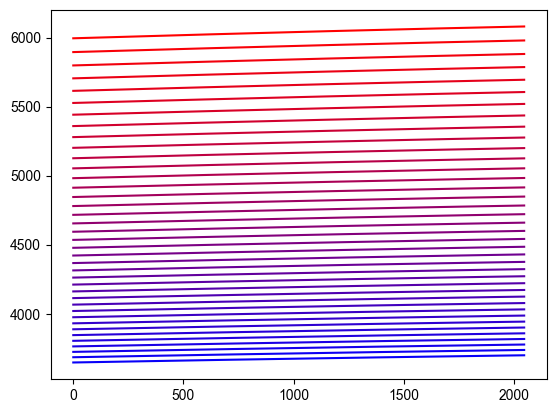

In [485]:
xidl_file = '/Users/yaqi/Desktop/pypeit_HIRES_orig/MAKEE/adrd-01_template.idl'

xidl_dict = readsav(xidl_file)
order_vec = xidl_dict['guess_ordr']
print(order_vec,'\n')
norders = order_vec.size
print(norders,'\n')
nspec = xidl_dict['sv_aspec'].shape[1]
print(nspec,'\n')
calib = xidl_dict['all_arcfit']
Table(calib[0:3])

for kk in range(norders):
    che_list = legend_val(calib['FFIT'][kk], np.arange(nspec), calib['NRM'][kk],calib['NORD'][kk])
    plt.plot(np.power(10,che_list),color=(1-kk/norders,0,kk/norders))

In [456]:
# transfer_list = [adrd_list,adrd97_list,aduv_list]
# XDISP_list = ['RED','RED97','UV']

# for n_list in range(3): 
#     i_list = transfer_list[n_list]
#     XDISP = XDISP_list[n_list]
#     for i in range(len(i_list)):
#         i_file = os.path.join(basename,i_list[i]['root_name']+'_template.idl')
#         xidl_dict = readsav(xidl_file)
#         norders = order_vec.size
#         nspec = xidl_dict['sv_aspec'].shape[1]
#         calib = xidl_dict['all_arcfit']
        
#         for kk in range(norders):
#             che_list = legend_val(calib['FFIT'][kk], np.arange(nspec), calib['NRM'][kk],calib['NORD'][kk])
#             plt.plot(che_list,color=(1-kk/norders,0,kk/norders))

#         plt.title(i_list[i]['root_name']+'_template')
#         plt.savefig(i_list[i]['root_name']+'_template.pdf')

## check arxiv_file

In [463]:
arxiv_file = '/Users/yaqi/Desktop/pypeit_HIRES_orig/generated_orig/hires_wvcalib_xidl.fits'

In [479]:
arxiv = Table.read(arxiv_file, hdu=2)
arxiv[0:3]

filename,nsolns,nsolns_good,bluest_order,bluest_good_order,reddest_order,reddest_good_order,xdisp_file,ech_angle_file,xd_angle_file,det_file,order,populated,populated_and_good,ech_angle,xd_angle,xdisp,det,binspec,lambda_cen,coeff,wave,arcspec
bytes30,int64,int64,int64,int64,int64,int64,bytes5,float64,float64,int64,int64[73],bool[73],bool[73],float64[73],float64[73],bytes5[73],int64[73],int64[73],float64[73],"float64[73,5]","float64[73,2048]","float64[73,2048]"
adrd-01_template.idl,39,39,97,97,59,59,RED,0.0,-0.672,1,0 .. 0,False .. False,False .. False,-10000000000.0 .. -10000000000.0,-10000000000.0 .. -10000000000.0,-- .. --,0 .. 0,0 .. 0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0
adrd-02_template.idl,39,39,97,97,59,59,RED,-0.2,-0.672,1,0 .. 0,False .. False,False .. False,-10000000000.0 .. -10000000000.0,-10000000000.0 .. -10000000000.0,-- .. --,0 .. 0,0 .. 0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0
adrd-03_template.idl,38,38,96,96,59,59,RED,0.2,-0.672,1,0 .. 0,False .. False,False .. False,-10000000000.0 .. -10000000000.0,-10000000000.0 .. -10000000000.0,-- .. --,0 .. 0,0 .. 0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0,0.0 .. 0.0


In [475]:
len(np.where(arxiv['xdisp_file']=='UV')[0])

25

In [476]:
len(np.where(arxiv['xdisp_file']=='RED')[0])

80

In [477]:
len(np.where(arxiv['xdisp_file']=='RED97')[0])

76